In [95]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

First, we'll pull in the cleaned data.

In [96]:
df = pd.read_csv('all_members_long_form_cleaned.csv')
df.head()

,neon_id,has_op_id,has_discourse_id,distance_from_asmbly,time_from_asmbly,age,gender,referral_source,family_membership,membership_cancelled,...,cum_skedda_booking_count,cum_skedda_booking_minutes,cum_num_classes_attended,cum_dollars_spent,cum_woodshop_classes,cum_metal_shop_classes,cum_electronics_classes,cum_textiles_classes,cum_lasers_classes,cum_3dp_classes
0,2742,True,True,17715.0,1369.0,35.0,Male,Google,True,True,...,0.0,0.0,4.0,1110.0,2.0,2.0,0.0,0.0,0.0,0.0
1,2837,False,True,17133.0,1336.0,35.0,Male,Google,False,False,...,2.0,120.0,1.0,175.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2837,False,True,17133.0,1336.0,35.0,Male,Google,False,False,...,12.0,1890.0,2.0,280.0,0.0,2.0,0.0,0.0,0.0,0.0
3,2837,False,True,17133.0,1336.0,35.0,Male,Google,False,False,...,16.0,2610.0,2.0,355.0,0.0,2.0,0.0,0.0,0.0,0.0
4,2837,False,True,17133.0,1336.0,35.0,Male,Google,False,True,...,16.0,2610.0,2.0,430.0,0.0,2.0,0.0,0.0,0.0,0.0


Let's take a look at the correlation coefficients to see if we have any colinearity issues.

<Axes: >

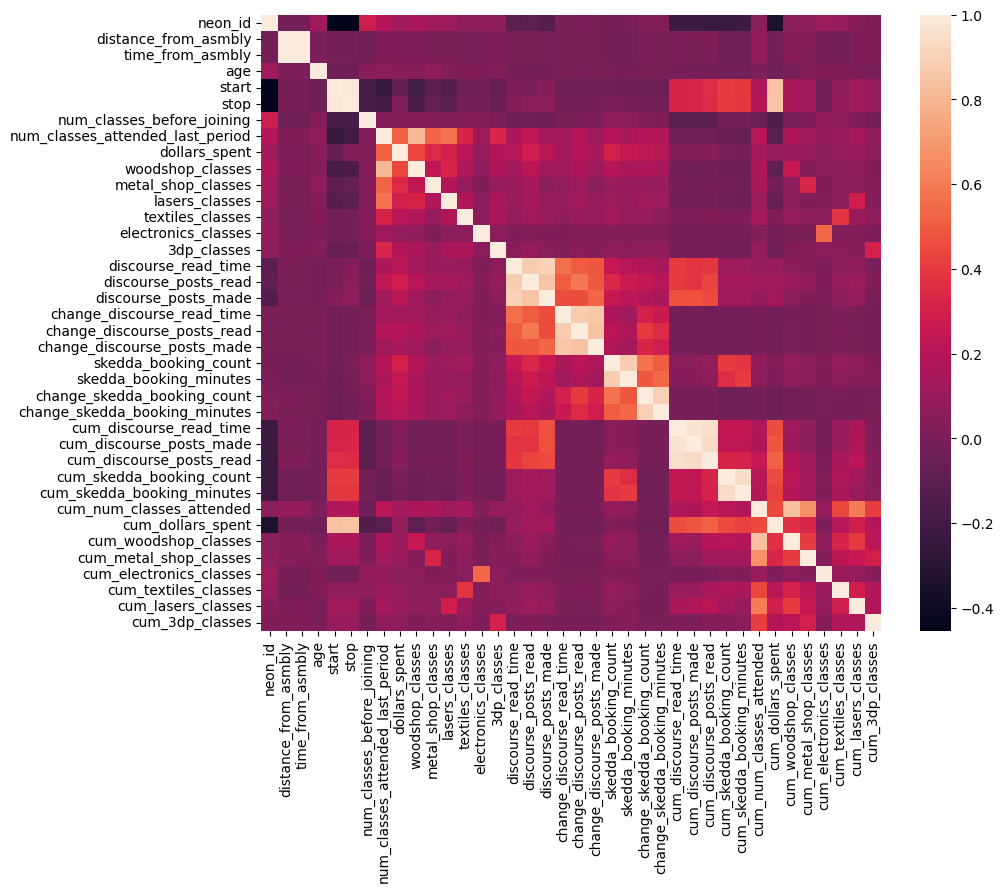

In [97]:
corr = df.select_dtypes('number').corr()

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(corr, ax=ax)


We can see that we have a few variables that are quite
highly correlated ($\rho > 0.8$). The skedda and discourse stats all appear to be highly correlated with
one another, so we'll pick a single variable from each to use for the regression. Unsurprisngly,
distance and time from Asmbly are almost perfectly correlated, so we'll drop the distance variable.

In [98]:
highly_corr_vars = [
    "distance_from_asmbly",
    "skedda_booking_minutes",
    "change_skedda_booking_minutes",
    "cum_skedda_booking_minutes",
    "discourse_posts_made",
    "change_discourse_posts_made",
    "cum_discourse_posts_made",
    "discourse_posts_read",
    "change_discourse_posts_read",
    "cum_discourse_posts_read"
]

df.drop(columns=highly_corr_vars, inplace=True)

<Axes: >

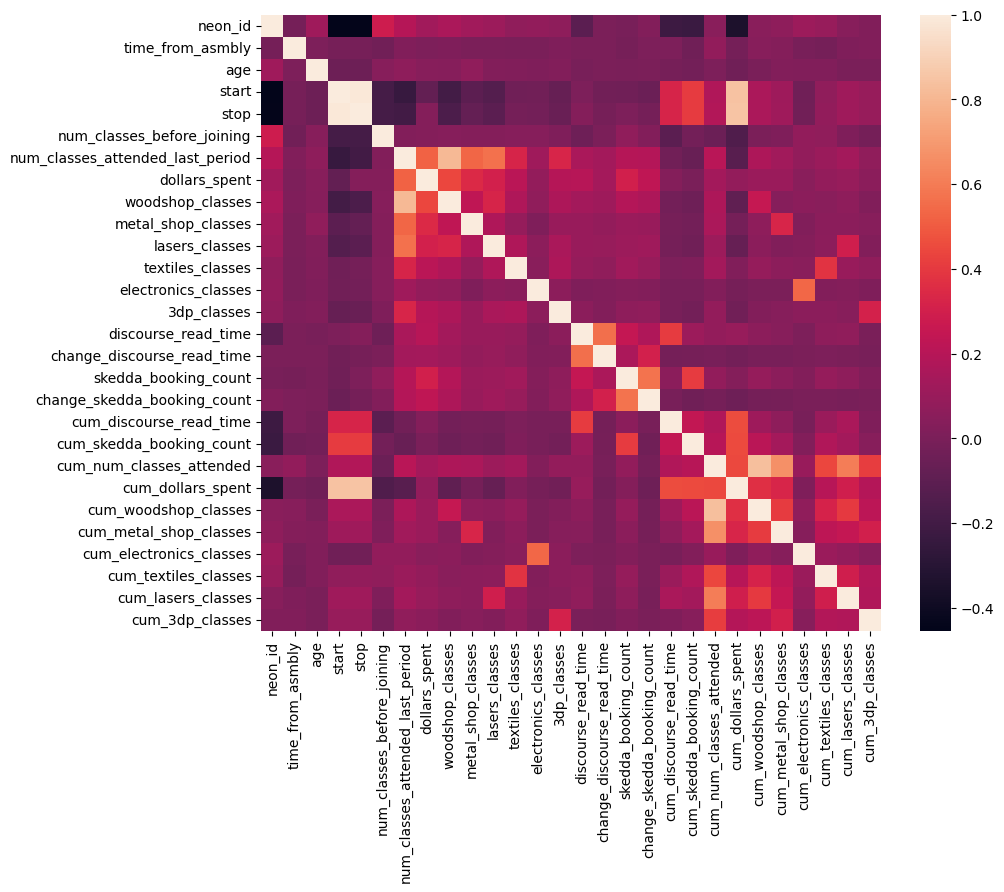

In [99]:
new_corr = df.select_dtypes('number').corr()

fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(new_corr)

Much better. Additionally, we might need to one hot encode the cateogorical vars and min-max
scale the numerical vars, but that will depend on the model we choose, so we'll take care of
this in the model fitting notebook.

In the meantime, let's see if we have any outliers in the age and time from asmbly variables we need to address.

<Axes: >

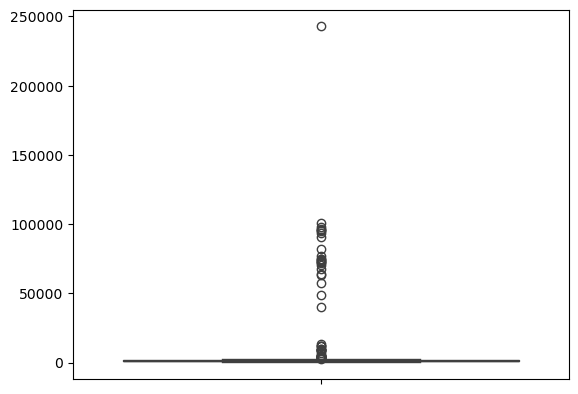

In [100]:
sns.boxplot(df["time_from_asmbly"].unique())

In [101]:
len(df[df.time_from_asmbly > 10800]["neon_id"].unique())

29

Clearly, we have some large outliers. Most likely, these very high values are previous addresses or members with a primary address elsewhere.
We'll replace values over the threshold of 3 hours (10,800 seconds) with the median value, since it's
highly unlikely these members are/were regularly driving that distance to Asmbly. There are only 29 
values higher than this threshold (of ~1250).

In [102]:
time_med = df["time_from_asmbly"].median()

df.loc[df["time_from_asmbly"] > 10800, "time_from_asmbly"] = time_med

<Axes: >

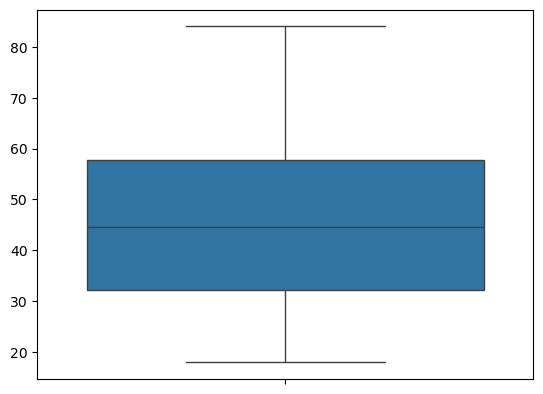

In [103]:
sns.boxplot(df["age"].unique())

We don't appear to have any large outliers/impossible values in the age variable.

In [104]:
df.to_csv("ready_for_modelling_long_form.csv", index=False)